In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
def prepare_dataset(df):
    df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
    df = df.fillna({'Age': df['Age'].mean()})
    df['Age'] /= 100
    df['Fare'] /= 100
    df['_bias'] = 1
    if 'Survived' in df.columns:
        return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
    else:
        return df

In [4]:
train_data = pd.read_csv('../data/titanic/train.csv')
train_features, train_answers = prepare_dataset(train_data)

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
X = train_features[features].to_numpy()
y = train_answers.to_numpy()

common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
X, y = X[X.shape[0] // 10:], y[X.shape[0] // 10:]

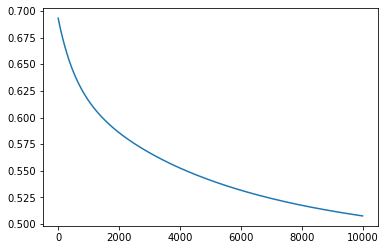

In [32]:
from tqdm.notebook import tqdm
iterations = 10000
alpha = 5e-4
tau = 1e-4

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

w = np.zeros((X.shape[1]))
errors = []
best_w = w
best_err = None
for it in tqdm(range(iterations)):
    errors.append(tau / 2 * np.sum(w**2) +
                  -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                 )
    if best_err is None or errors[-1] < best_err:
        best_w = w
        best_err = errors[-1]
    w -= alpha * (-np.array([
        np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
        for j in range(X.shape[1])
    ]) / X.shape[0] + tau * w)
    if it % 2000 == 0: alpha *= 0.99

plt.plot([i for i in range(len(errors))], errors)

In [34]:
train_predictions = (sigmoid(common_test_X @ w) >= 0.5).astype(np.int) * 2 - 1
print('Score: {}'.format( np.mean( train_predictions == common_test_y ) ))

Score: 0.7528089887640449


In [35]:
topology_pair = [(0, 1)]
topology_cycle_3 = [(0, 1), (1, 2), (2, 0)] 
topology_grid_5 = [('center', 'west'), ('center', 'east'), ('center', 'north'), ('center', 'south'),
                   ('west', 'north'), ('north', 'east'), ('east', 'south'), ('west', 'south')]
'''
     @
    /|\
   @-@-@  topology_grid_5
    \|/
     @
'''
from utils.consensus_asyncio import *

In [36]:
def split_data(X, y, topology):
    tmpX = X.copy()
    tmpy = y.copy()
    tokens = list(set(np.array(topology).flatten()))
    num = len(tokens)
    result = dict()
    for i in range(num):
        left_tokens = num - i
        left_data = len(tmpX)
        ln = left_data // left_tokens
        result[tokens[i]] = (tmpX[:ln], tmpy[:ln])
        tmpX, tmpy = tmpX[ln:], tmpy[ln:]
    return result

In [39]:
def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

progress_info = {}

async def learning_instance(X, y, agent, iterations=50000):
    alpha = 5e-4
    tau = 1e-4

    w = np.zeros((X.shape[1]))
    errors = []
    for it in range(iterations):
        errors.append(tau / 2 * np.sum(w**2) +
                      -np.mean(np.log( sigmoid(common_test_y * (common_test_X @ w)) ) )
                     )
        grad = -np.array([
            np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
            for j in range(X.shape[1])
        ]) / X.shape[0] + tau * w
        w -= alpha * grad
        w = await agent.run_round(w, X.shape[0])
        if it % 2000 == 0: alpha *= 0.99
        progress_info[agent.token] = (it + 1) / iterations

    return w, errors[-1], errors

async def run(topology, iterations=100, timeout=None, debug=False):
    dl_data = split_data(X, y, topology)
    consensus_shutdown = asyncio.Queue()
    consensus_network = ConsensusNetwork(topology, consensus_shutdown, debug=debug)
    agents = [ConsensusAgent(token, convergence_eps=1e-5, debug=debug) for token in consensus_network.tokens]
    for a in agents:
        consensus_network.register_agent(a)

    async def print_progress():
        from ipywidgets import IntProgress, FloatProgress, FloatText
        from IPython.display import display

        progress = FloatProgress(min=0.0, max=1.0, step=0.01, value=0.0)
        display(progress)
        while True:
            v = list(progress_info.values())
            if len(v) > 0:
                p = np.mean(v)
                progress.value = p
            await asyncio.sleep(0.25)

    if timeout:
        asyncio.create_task(shutdown_after_timeout(consensus_shutdown, timeout))
    progress_task = asyncio.create_task(print_progress())
    tasks = [asyncio.create_task(
                learning_instance(dl_data[a.token][0], dl_data[a.token][1], a, iterations=iterations)
             ) for a in agents]
    asyncio.create_task(consensus_network.serve())
    best_ws = []
    for coro in asyncio.as_completed(tasks):
        best_w, best_err, errors = await coro
        best_ws.append(best_w)
        plt.plot([i for i in range(len(errors))], errors)
    plt.suptitle('Local learning error across agents')
    progress_task.cancel()

    for w in best_ws:
        test_predictions = (sigmoid(common_test_X @ w) >= 0.5).astype(np.int) * 2 - 1
        print(f'Score: {np.mean( test_predictions == common_test_y )}')

    for w in best_ws:
        print(f'W: {w}')

FloatProgress(value=0.0, max=1.0)

Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
W: [ -4.74466655 -13.55821822   0.34522721  -0.17540334   1.64527491
   5.27545747   2.434224  ]
W: [ -4.74466739 -13.55822076   0.34522727  -0.17540331   1.64527526
   5.27545845   2.43422446]
W: [ -4.74466747 -13.55822072   0.34522727  -0.17540343   1.64527517
   5.27545844   2.43422446]
W: [ -4.74466057 -13.55820115   0.34522679  -0.17540305   1.6452728
   5.27545085   2.43422097]
W: [ -4.74466059 -13.55820119   0.34522675  -0.17540317   1.64527288
   5.27545081   2.43422091]


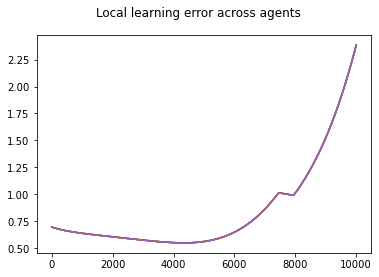

In [40]:
await run(topology_grid_5, 10000) # test error

FloatProgress(value=0.0, max=1.0)

Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
W: [-0.75424251 -2.60742394  0.04702126 -0.14256186  0.31250887  0.95300719
  0.51015123]
W: [-0.75424234 -2.60742335  0.04702125 -0.14256182  0.3125088   0.95300697
  0.51015111]
W: [-0.75424083 -2.6074182   0.04702117 -0.14256148  0.31250817  0.9530051
  0.51015012]
W: [-0.75424252 -2.60742396  0.04702126 -0.14256186  0.31250887  0.95300719
  0.51015123]
W: [-0.75424159 -2.60742084  0.04702121 -0.14256163  0.31250849  0.95300606
  0.51015063]


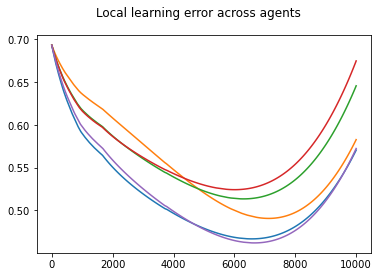

In [32]:
await run(topology_grid_5, 10000) # train error

In [28]:
from utils.consensus_titanic import ConsensusNode
from utils.master_titanic import MasterNode

TOP_5 = {
    0: {0: 0.85, 1: 0.05, 2: 0.05, 4: 0.05},
    1: {0: 0.05, 1: 0.85, 2: 0.05, 3: 0.05},
    2: {0: 0.05, 1: 0.05, 2: 0.8, 3: 0.05, 4: 0.05},
    3: {1: 0.05, 2: 0.05, 3: 0.85, 4: 0.05},
    4: {0: 0.05, 2: 0.05, 3: 0.05, 4: 0.85},
}

In [21]:
topology = TOP_5
n_agents = len(topology)

In [22]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    X_train=X,
                    y_train=y,
                    X_test=common_test_X,
                    y_test=common_test_y,
                    stat_step=100, # save statistic each stat step 
                    epoch=10000, # number of epochs
                    epoch_len=1, # length each epoch
                    epoch_cons_num=1 # the first epoch from which consensus begins
                   )

# init consensus nodes
master.initialize_nodes()

master.start_consensus()
print('Done!')

Done!


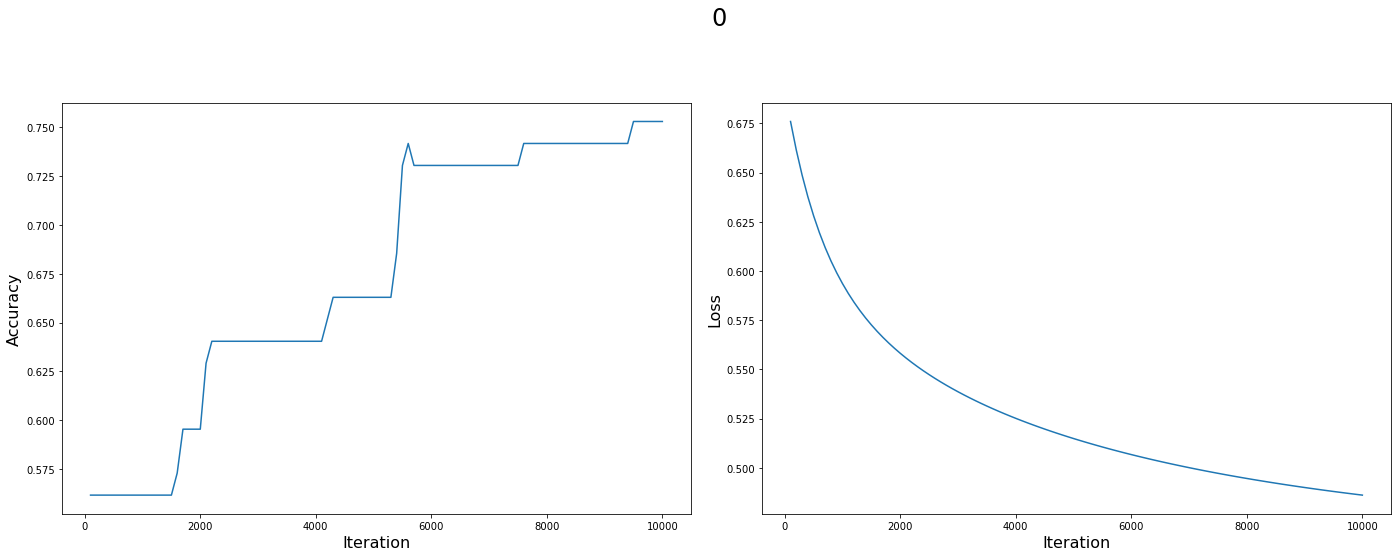

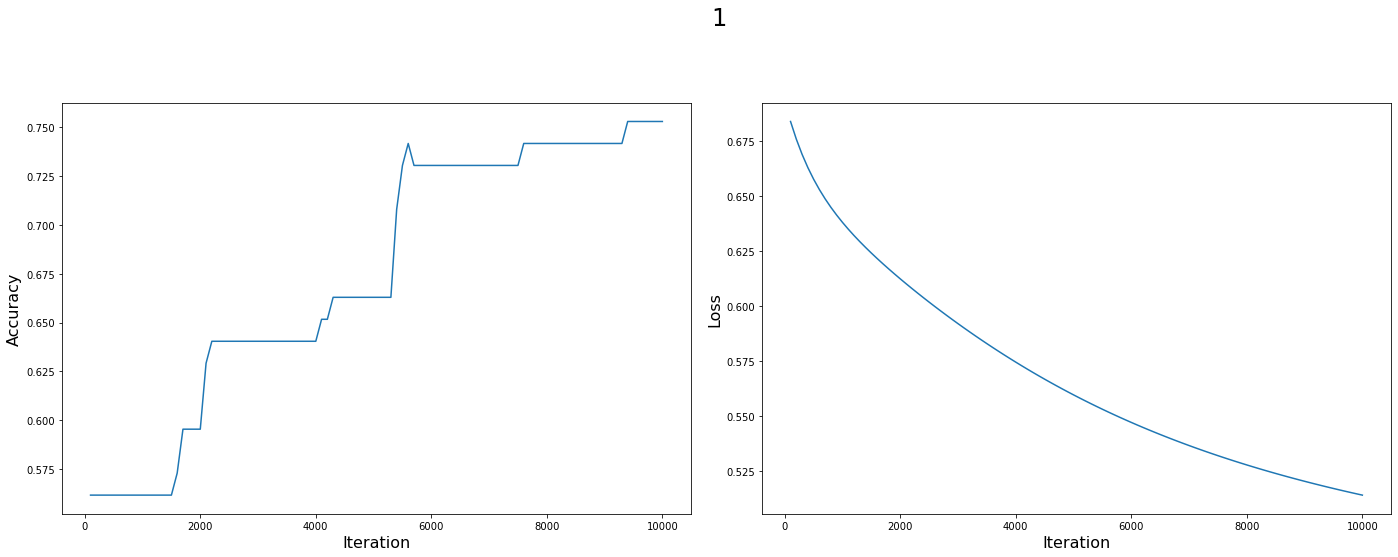

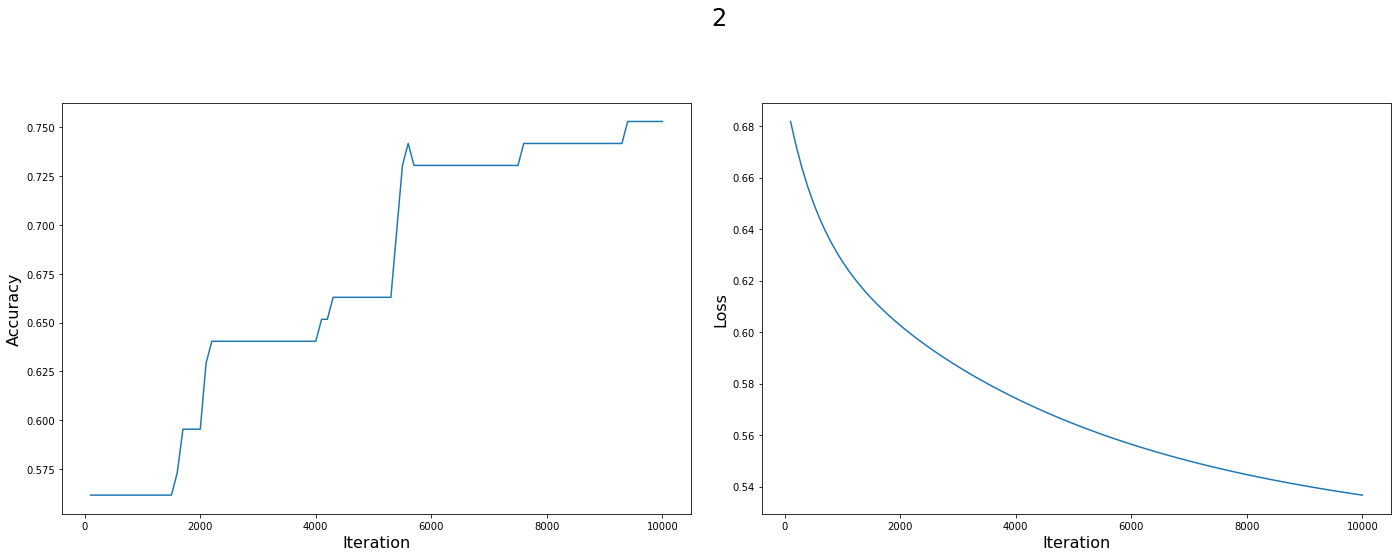

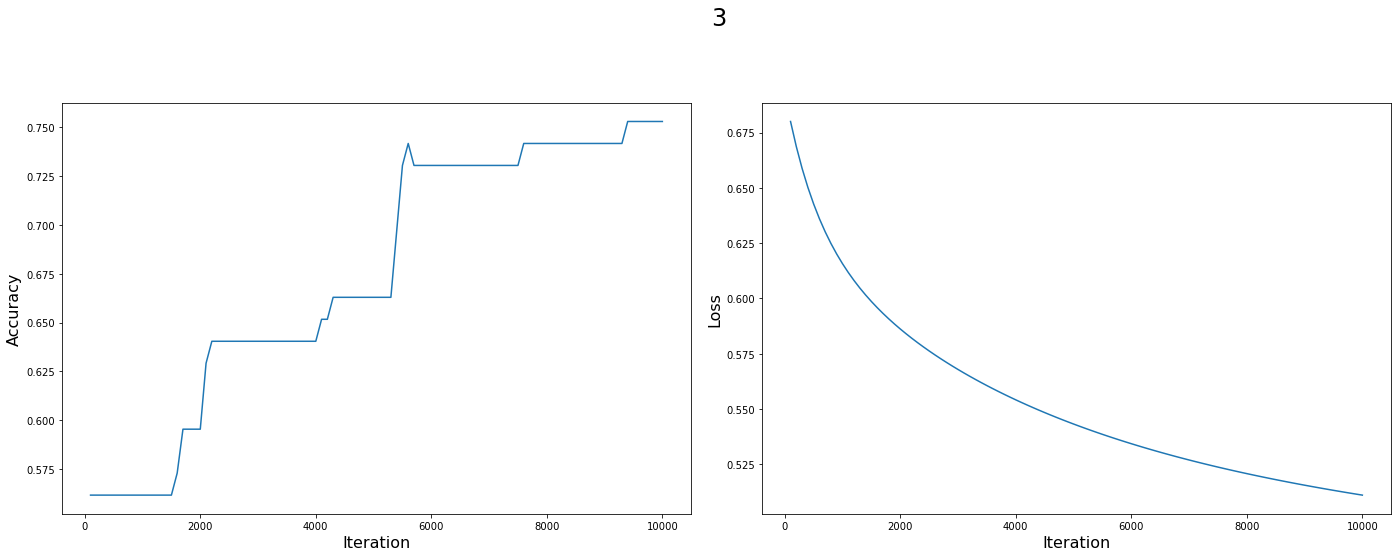

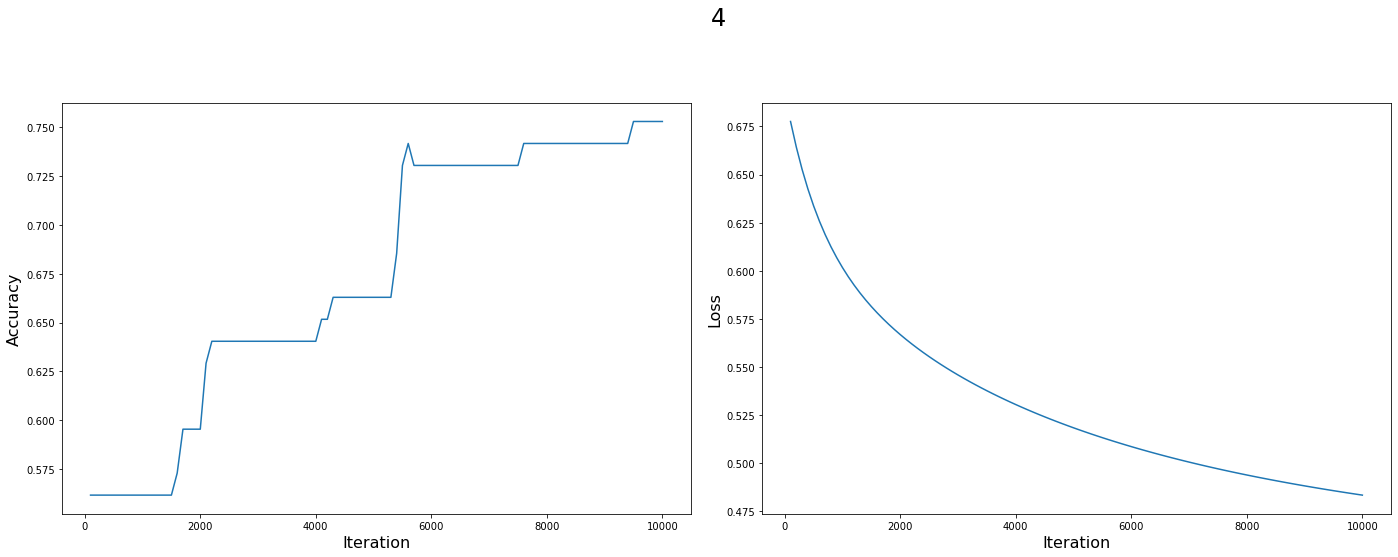

In [23]:
# Accuracy and loss plots for each node
for node in master.network.values():
    node.show_graphs()